In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Load Heart Rate Data
file_path = '/home/Gurshan.R/Documents/GitHub/SYSC4907_Capstone/GAN_Resp_v2/infant_2_8h_respiration_rate_outlierRem.csv'  # Replace with your actual file path
df = pd.read_csv(file_path)

# Ensure the heart rate column exists
columns = ['respiration_rate']  # Replace with the correct column name for Resp rate
if columns[0] not in df.columns:
    raise ValueError(f"Column '{columns[0]}' not found in the dataset.")

# Normalization
data = df[columns].to_numpy().reshape(-1, 1)  # Extract Resp rate data

# Confirm data range
min_data_value = data.min()
max_data_value = data.max()
print(f"Data range before normalization: {min_data_value} to {max_data_value}")

# Normalize the data
min_val, max_val = 30, 100  # Known neonate Resp rate range
data_normalized = (data - min_val) / (max_val - min_val)  # Normalize to [0, 1]
data_normalized = torch.tensor(data_normalized, dtype=torch.float32)

# Ensure normalization was successful
print(f"Data range after normalization: {data_normalized.min().item()} to {data_normalized.max().item()}")


Data range before normalization: 25.86206896551724 to 136.36363636363637
Data range after normalization: -0.05911330133676529 to 1.5194804668426514


In [4]:
# Define Generator
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()  # Outputs normalized data in [0, 1]
        )

    def forward(self, noise):
        return self.model(noise)

In [5]:
# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()  # Output probability of being real
        )

    def forward(self, x):
        return self.model(x)

In [6]:
# Initialize Generator and Discriminator
noise_dim = 10
generator = Generator(noise_dim).to(device)
discriminator = Discriminator().to(device)

In [7]:
# Loss and Optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

In [8]:
# Training Loop
epochs = 5000
batch_size = 16
real_labels = torch.ones(batch_size, 1).to(device)
fake_labels = torch.zeros(batch_size, 1).to(device)

In [9]:
for epoch in range(epochs):
    # Train Discriminator
    discriminator.zero_grad()
    idx = torch.randint(0, data_normalized.size(0), (batch_size,))  # Random sampling
    real_data = data_normalized[idx].to(device)
    real_loss = criterion(discriminator(real_data), real_labels)

    noise = torch.randn(batch_size, noise_dim).to(device)
    fake_data = generator(noise).detach()
    fake_loss = criterion(discriminator(fake_data), fake_labels)
    d_loss = real_loss + fake_loss
    d_loss.backward()
    optimizer_D.step()

    # Train Generator
    generator.zero_grad()
    noise = torch.randn(batch_size, noise_dim).to(device)
    fake_data = generator(noise)
    g_loss = criterion(discriminator(fake_data), real_labels)
    g_loss.backward()
    optimizer_G.step()

    # Print losses every 500 epochs
    if epoch % 500 == 0:
        print(f"Epoch [{epoch}/{epochs}] D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

Epoch [0/5000] D Loss: 1.4176, G Loss: 0.8781
Epoch [500/5000] D Loss: 1.3975, G Loss: 0.6952
Epoch [1000/5000] D Loss: 1.3870, G Loss: 0.7077
Epoch [1500/5000] D Loss: 1.3685, G Loss: 0.6975
Epoch [2000/5000] D Loss: 1.3759, G Loss: 0.6995
Epoch [2500/5000] D Loss: 1.3885, G Loss: 0.7044
Epoch [3000/5000] D Loss: 1.3918, G Loss: 0.6726
Epoch [3500/5000] D Loss: 1.3846, G Loss: 0.6919
Epoch [4000/5000] D Loss: 1.3885, G Loss: 0.7341
Epoch [4500/5000] D Loss: 1.3546, G Loss: 0.7380


In [10]:
# Generate Synthetic Data
with torch.no_grad():
    noise = torch.randn(96, noise_dim).to(device)
    synthetic_data = generator(noise).cpu().numpy()

In [11]:
# Denormalize real and synthetic data for plotting
real_data_denormalized = data_normalized.numpy() * (max_val - min_val) + min_val

# If synthetic_data is already a numpy array, use it directly
synthetic_data_denormalized = synthetic_data * (max_val - min_val) + min_val

In [12]:
# Confirm denormalization
print(f"Real Data range after denormalization: {real_data_denormalized.min()} to {real_data_denormalized.max()}")
print(f"Synthetic Data range after denormalization: {synthetic_data_denormalized.min()} to {synthetic_data_denormalized.max()}")

Real Data range after denormalization: 25.86206817626953 to 136.36363220214844
Synthetic Data range after denormalization: 30.01041603088379 to 99.97713470458984


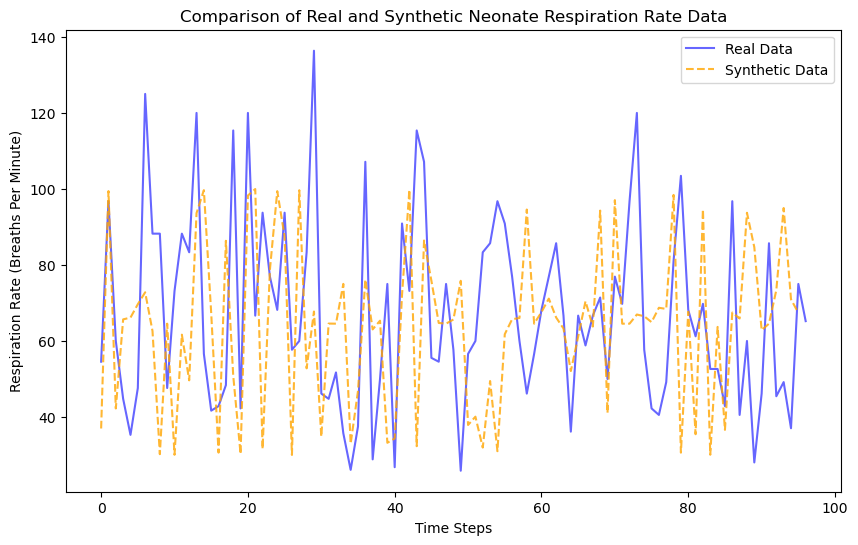

In [13]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(real_data_denormalized, label="Real Data", color="blue", alpha=0.6)
plt.plot(synthetic_data_denormalized, label="Synthetic Data", color="orange", linestyle="--", alpha=0.8)
plt.xlabel("Time Steps")
plt.ylabel("Respiration Rate (Breaths Per Minute)")
plt.title("Comparison of Real and Synthetic Neonate Respiration Rate Data")
plt.legend()
plt.show()

In [14]:
# Save the trained generator's state dictionary
torch.save(generator.state_dict(), 'trained_generator_ResprationRate_again.pth')

# Evaluation Code

In [15]:
# Quantitative Evaluation Metrics
import numpy as np
from scipy.stats import ks_2samp, wasserstein_distance, skew, kurtosis

# Flatten the denormalized data arrays
real_flat = real_data_denormalized.flatten()
syn_flat = synthetic_data_denormalized.flatten()

# 1. Kolmogorov–Smirnov (KS) Test
ks_stat, ks_p_value = ks_2samp(real_flat, syn_flat)
print(f"KS Test Statistic: {ks_stat:.4f}, p-value: {ks_p_value:.4f}")

# 2. Wasserstein Distance (Earth Mover's Distance)
w_distance = wasserstein_distance(real_flat, syn_flat)
print(f"Wasserstein Distance: {w_distance:.4f}")

# 3. Summary Statistics Comparison
real_mean = np.mean(real_flat)
real_std = np.std(real_flat)
syn_mean = np.mean(syn_flat)
syn_std = np.std(syn_flat)
print(f"Real Data Mean: {real_mean:.4f}, STD: {real_std:.4f}")
print(f"Synthetic Data Mean: {syn_mean:.4f}, STD: {syn_std:.4f}")

# 4. Skewness and Kurtosis
real_skew = skew(real_flat)
syn_skew = skew(syn_flat)
real_kurt = kurtosis(real_flat)
syn_kurt = kurtosis(syn_flat)
print(f"Real Data Skewness: {real_skew:.4f}, Kurtosis: {real_kurt:.4f}")
print(f"Synthetic Data Skewness: {syn_skew:.4f}, Kurtosis: {syn_kurt:.4f}")


KS Test Statistic: 0.2032, p-value: 0.0290
Wasserstein Distance: 6.8880
Real Data Mean: 67.1746, STD: 24.9199
Synthetic Data Mean: 63.9916, STD: 20.7719
Real Data Skewness: 0.5938, Kurtosis: -0.2248
Synthetic Data Skewness: -0.0374, Kurtosis: -0.7654
